In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import fastai
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback

In [2]:
DATA_PATH = '../data/'
PATH = '../tmp'

In [3]:
import os
files = os.listdir(DATA_PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['scalar_coupling_contributions.csv',
 'mulliken_charges.csv',
 'structures.csv',
 'test.csv',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'sample_submission.csv',
 'potential_energy.csv']

In [4]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
test_df = pd.read_csv(DATA_PATH+'test.csv')
structures_df = pd.read_csv(DATA_PATH+'structures.csv')
scc_df = pd.read_csv(DATA_PATH+'scalar_coupling_contributions.csv')
mc_df = pd.read_csv(DATA_PATH+'mulliken_charges.csv')
mst_df = pd.read_csv(DATA_PATH+'magnetic_shielding_tensors.csv')
dm_df = pd.read_csv(DATA_PATH+'dipole_moments.csv')
pe_df = pd.read_csv(DATA_PATH+'potential_energy.csv')

In [5]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [6]:
%%time
train_df = map_atom_info(train_df, 0)
train_df = map_atom_info(train_df, 1)
test_df = map_atom_info(test_df, 0)
test_df = map_atom_info(test_df, 1)

CPU times: user 28.6 s, sys: 6.29 s, total: 34.9 s
Wall time: 10.9 s


In [7]:
train_p_0 = train_df[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_df[['x_1', 'y_1', 'z_1']].values
test_p_0 = test_df[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_df[['x_1', 'y_1', 'z_1']].values

In [8]:
%%time
train_df['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test_df['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

CPU times: user 695 ms, sys: 220 ms, total: 915 ms
Wall time: 158 ms


In [9]:
%%time
train_df['dist_to_type_mean'] = train_df['dist'] / train_df.groupby('type')['dist'].transform('mean')
test_df['dist_to_type_mean'] = test_df['dist'] / test_df.groupby('type')['dist'].transform('mean')

CPU times: user 2.48 s, sys: 1.14 s, total: 3.61 s
Wall time: 620 ms


In [10]:
%%time
atoms_per_molecule_df = structures_df.groupby(['molecule_name', 'atom']).count()
atoms_per_molecule_map = atoms_per_molecule_df['atom_index'].unstack().fillna(0).astype(int).to_dict()

CPU times: user 2.16 s, sys: 391 ms, total: 2.55 s
Wall time: 628 ms


In [11]:
%%time
pd.options.mode.chained_assignment = None
atoms = structures_df['atom'].unique()
train_df['num_atoms'] = 0
test_df['num_atoms'] = 0
for atom in atoms:
    train_df[f'num_{atom}_atoms'] = train_df['molecule_name'].map(atoms_per_molecule_map[atom])
    train_df['num_atoms'] += train_df[f'num_{atom}_atoms']
    test_df[f'num_{atom}_atoms'] = test_df['molecule_name'].map(atoms_per_molecule_map[atom])
    test_df['num_atoms'] += test_df[f'num_{atom}_atoms']

CPU times: user 13.2 s, sys: 1.94 s, total: 15.1 s
Wall time: 4.51 s


##  Fit Tabular Model

In [12]:
train_df_ = train_df.copy()
train_df = train_df_[:200000]

In [13]:
def emb_factors(n_cats):
    if n_cats > 1000: return 50
    else: return min((n_cats + 1) // 2, 50)

In [14]:
train_df.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'dist', 'dist_to_type_mean', 'num_atoms',
       'num_C_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms',
       'num_F_atoms'],
      dtype='object')

In [15]:
cat_vars = ['atom_0', 'atom_1', 'type', 'num_H_atoms', 'num_C_atoms',
            'num_H_atoms', 'num_N_atoms', 'num_O_atoms', 'num_F_atoms',
            'num_atoms']
cont_vars = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'dist', 'dist_to_type_mean']
target_var = 'scalar_coupling_constant'

In [16]:
unique_cats = train_df[cat_vars].nunique()

In [17]:
for f in cat_vars:
    train_df[f] = train_df[f].astype('category')
    test_df[f] = pd.Categorical(test_df[f], categories=train_df[f].cat.categories)

In [18]:
ss_target, ss = StandardScaler(), StandardScaler()

In [19]:
train_df[target_var] = ss_target.fit_transform(train_df[target_var].values.reshape(-1,1))
train_df[cont_vars] = ss.fit_transform(train_df[cont_vars].values)
test_df[cont_vars] = ss.transform(test_df[cont_vars].values)

In [20]:
y_mean, y_scale = ss_target.mean_[0], ss_target.scale_[0]

In [21]:
def group_mean_log_mae(y_true, y_pred, types):
    y_true, y_pred, types = y_true.cpu().numpy().ravel(), y_pred.cpu().numpy().ravel(), types.cpu().numpy().ravel()
    y_true = y_mean + y_true * y_scale
    y_pred = y_mean + y_pred * y_scale
    maes = pd.Series(y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes).mean()

class GroupMeanLogMAE(Callback):
    _order = -20 # Needs to run before the recorder
    types_cidx = 2

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['GroupMeanLogMAE'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            self.input.append(last_input[0])
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs[:, self.types_cidx])
            return add_metrics(last_metrics, [metric])

def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)

In [92]:
bs = 1024
layers = [1000, 500, 250, 100]
ps = [0.0, 0.01, 0.02, 0.02]
emb_drop = 0.03
wd = 0.002
use_bn = True
emb_szs = [(n_cats + 1, emb_factors(n_cats)) for n_cats in unique_cats]

In [93]:
train_idx, val_idx = train_test_split(train_df.index, test_size=0.25, shuffle=True, random_state=100)

In [94]:
db = (TabularList.from_df(train_df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=[])
        .split_by_idx(val_idx)
        .label_from_df(cols=target_var)
        .add_test(TabularList.from_df(test_df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=[]))
        .databunch(bs=bs))

In [95]:
set_seed(100)
model = TabularModel(emb_szs, len(db.cont_names), out_sz=1, layers=layers, ps=ps, emb_drop=emb_drop, 
                     y_range=None, use_bn=use_bn)

In [96]:
learn = Learner(db, model, metrics=[mean_absolute_error, root_mean_squared_error], 
                callback_fns=GroupMeanLogMAE, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


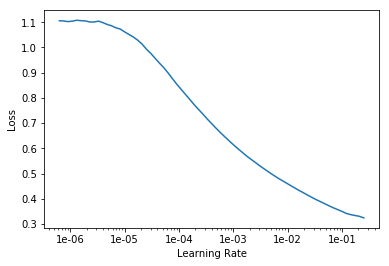

In [97]:
learn.lr_find(start_lr=1e-7, end_lr=10, num_it=100, stop_div=True)
learn.recorder.plot()

In [98]:
learn.fit_one_cycle(10, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name=f'starter')])

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,GroupMeanLogMAE,time
0,0.099103,0.076670,0.144219,0.276019,1.708212,00:18
1,0.043560,0.029539,0.100388,0.171460,1.184620,00:19
2,0.026811,0.020557,0.094752,0.143227,1.185980,00:19
3,0.021416,0.015904,0.081877,0.125918,1.033582,00:20
4,0.016778,0.012348,0.069910,0.110926,0.829796,00:22
5,0.015030,0.012091,0.073047,0.109819,0.912763,00:22
6,0.014241,0.010411,0.065042,0.101852,0.749114,00:21
7,0.013247,0.009954,0.062750,0.099584,0.706221,00:21
8,0.012245,0.009438,0.060186,0.096946,0.649348,00:20
9,0.011821,0.009242,0.059768,0.095933,0.638755,00:20


Better model found at epoch 0 with GroupMeanLogMAE value: 1.7082124948501587.
Better model found at epoch 1 with GroupMeanLogMAE value: 1.1846199035644531.
Better model found at epoch 3 with GroupMeanLogMAE value: 1.0335824489593506.
Better model found at epoch 4 with GroupMeanLogMAE value: 0.8297963738441467.
Better model found at epoch 6 with GroupMeanLogMAE value: 0.7491143345832825.
Better model found at epoch 7 with GroupMeanLogMAE value: 0.7062205672264099.
Better model found at epoch 8 with GroupMeanLogMAE value: 0.6493479013442993.
Better model found at epoch 9 with GroupMeanLogMAE value: 0.6387554407119751.


In [99]:
learn.fit_one_cycle(10, max_lr=2e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name=f'starter')])

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,GroupMeanLogMAE,time
0,0.011980,0.009442,0.060610,0.096976,0.659622,00:22
1,0.011940,0.009731,0.061538,0.098441,0.685434,00:21
2,0.012521,0.010669,0.062249,0.103058,0.723336,00:20
3,0.011922,0.009881,0.061954,0.099182,0.699885,00:19
4,0.011938,0.009422,0.059652,0.096888,0.642664,00:20
5,0.011474,0.009176,0.058642,0.095578,0.625016,00:20
6,0.011153,0.008718,0.058231,0.093156,0.620082,00:20
7,0.011139,0.008850,0.057535,0.093857,0.605339,00:20
8,0.010737,0.008643,0.056900,0.092752,0.590849,00:20
9,0.010524,0.008570,0.057328,0.092367,0.595767,00:20


Better model found at epoch 0 with GroupMeanLogMAE value: 0.6596221923828125.
Better model found at epoch 4 with GroupMeanLogMAE value: 0.6426637172698975.
Better model found at epoch 5 with GroupMeanLogMAE value: 0.6250155568122864.
Better model found at epoch 6 with GroupMeanLogMAE value: 0.6200818419456482.
Better model found at epoch 7 with GroupMeanLogMAE value: 0.6053394079208374.
Better model found at epoch 8 with GroupMeanLogMAE value: 0.5908493995666504.


In [100]:
learn.fit_one_cycle(10, max_lr=4e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name=f'starter')])

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,GroupMeanLogMAE,time
0,0.010557,0.008611,0.058418,0.092600,0.620710,00:20
1,0.010457,0.008558,0.057077,0.092292,0.592842,00:20
2,0.010643,0.008884,0.057387,0.094029,0.604895,00:20
3,0.010783,0.008537,0.057493,0.092191,0.599090,00:21
4,0.010666,0.008888,0.058797,0.094050,0.649862,00:19
5,0.010804,0.008560,0.056794,0.092306,0.594242,00:19
6,0.010130,0.008439,0.057131,0.091658,0.597672,00:19
7,0.010332,0.008544,0.056290,0.092209,0.579569,00:19
8,0.010203,0.008502,0.056271,0.091985,0.580714,00:19
9,0.010372,0.008523,0.056492,0.092101,0.580836,00:19


Better model found at epoch 0 with GroupMeanLogMAE value: 0.6207100749015808.
Better model found at epoch 1 with GroupMeanLogMAE value: 0.592842161655426.
Better model found at epoch 7 with GroupMeanLogMAE value: 0.5795690417289734.


In [101]:
learn.fit_one_cycle(10, max_lr=1e-5, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='GroupMeanLogMAE',  name=f'starter')])

epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,GroupMeanLogMAE,time
0,0.009919,0.008432,0.057701,0.091621,0.608489,00:19
1,0.010226,0.008414,0.056481,0.091513,0.580918,00:19
2,0.010339,0.008755,0.056980,0.093338,0.602349,00:19
3,0.010350,0.008370,0.056277,0.091267,0.578771,00:19
4,0.010029,0.008417,0.056171,0.091524,0.577178,00:19
5,0.010236,0.008393,0.056115,0.091394,0.577814,00:19
6,0.010077,0.008364,0.056728,0.091240,0.591419,00:19
7,0.010215,0.008409,0.057473,0.091495,0.606966,00:19
8,0.010029,0.008393,0.056240,0.091391,0.577806,00:19
9,0.009850,0.008515,0.056243,0.092050,0.581022,00:20


Better model found at epoch 0 with GroupMeanLogMAE value: 0.6084885001182556.
Better model found at epoch 1 with GroupMeanLogMAE value: 0.5809175968170166.
Better model found at epoch 3 with GroupMeanLogMAE value: 0.5787707567214966.
Better model found at epoch 4 with GroupMeanLogMAE value: 0.5771781802177429.


In [30]:
pred, _ = learn.get_preds()
pred_test, _ = learn.get_preds(DatasetType.Test)